In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import pathlib
import pysam
import pyfaidx
import warnings
import re
import argparse
import sys
from tqdm import tqdm 
tqdm.pandas()
warnings.filterwarnings("ignore")

path_to_all_fa = "/media/hieunguyen/GSHD_HN01/storage/resources/hg19"
paneldf = pd.read_excel("../panel_design/All_panel_designs_20250601.xlsx", sheet_name = "Lung_panel_version_1.1")

genome_version = "hg19"
# output_type = "connor"
output_type = "raw"

path_to_main_output = "/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7288_R7297_old/data_analysis"
path_to_01_output = os.path.join(path_to_main_output, output_type, "01_output")
os.system(f"mkdir -p {path_to_01_output}")

def get_refseq(path_to_all_fa, chrom, start, end):
        refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "{}.fa".format(chrom)))
        return(str.upper(refseq.get_seq(name = "{}".format(chrom), start = start, end = end).seq))

##### get list of all real cpg for this panel
cpgdf = pd.DataFrame()
for region in paneldf[genome_version].unique():
    region_name = paneldf[paneldf[genome_version] == region]["Amplicon"].values[0]
    chrom = region.split(":")[0].replace("chr", "")
    start = int(region.split(":")[1].split("-")[0])
    end = int(region.split(":")[1].split("-")[1])
    refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "chr{}.fa".format(chrom)))
    refseq_at_region = str.upper(refseq.get_seq(name = "chr{}".format(chrom), start = start, end = end).seq)

    all_cpg_in_cluster = [m.start(0) for m in re.finditer("CG", refseq_at_region)]
    cpg_coords = [f"chr{chrom}:{item + start}-{item + start + 1}" for item in all_cpg_in_cluster]

    tmp_cpgdf = pd.DataFrame(data = cpg_coords, columns = ["CpG"])
    tmp_cpgdf["region"] = region
    tmp_cpgdf["region_name"] = region_name
    cpgdf = pd.concat([cpgdf, tmp_cpgdf], axis = 0)

cpgdf = cpgdf[["region", "CpG", "region_name"]]

covdir = "/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7288_R7297_old/BISMARK_COV"

# fetch .connor.bam files only, UMI pre-processed files
if output_type == "connor":
    all_cov_files = [item for item in pathlib.Path(covdir).glob("*.cov") if "connor" in item.name]
if output_type == "raw":
    all_cov_files = [item for item in pathlib.Path(covdir).glob("*.cov") if "trimmed" in item.name]

print(f"Number of input cov file in this folder: {len(all_cov_files)}")
metadata = pd.DataFrame(data = [str(item) for item in all_cov_files], columns = ["path"])
metadata["SampleID"] = metadata["path"].apply(lambda x: x.split("/")[-1].split(".connor")[0].split("_")[0].split("-")[1])
metadata["Sample"] = metadata["SampleID"].apply(lambda x: x.replace("TM", "") if "PANEL" in x else f"S{x.split('S')[1]}")
metadata["amplicon"] = metadata[["SampleID", "Sample"]].apply(lambda x: x[0].replace("TM", "").replace(x[1], ""), axis = 1)
metadata["BAM"] = metadata["path"].apply(lambda x: x.replace("bedGraph.gz.bismark.zero.cov", "bam").replace("BISMARK_COV", "BISMARK_ALIGNMENT"))

proc_cov_path = []
for input_cov_file in metadata.path.to_list():
    sampleid = input_cov_file.split("/")[-1].split(".connor")[0]
    if os.path.isfile(os.path.join(path_to_01_output, f"{sampleid}_cov.xlsx")) == False:
        covdf = pd.read_csv(input_cov_file, header = None, sep = "\t")
        covdf.columns = ["chrom", "start", "end", "meth_density", "countC", "countT"]
        covdf = covdf[covdf["chrom"].isin(["chrX", "chrY", "chrMT"]) == False]
        covdf = covdf[covdf["chrom"].str.contains("chrUn") == False]
        covdf = covdf[covdf["chrom"].str.contains("_") == False]
        covdf["seq"] = covdf[["chrom", "start"]].progress_apply(lambda x: get_refseq(path_to_all_fa= path_to_all_fa, 
                                                                chrom = x[0], start = x[1], end = x[1] + 1), axis = 1)
        covdf["strand"] = covdf["seq"].apply(lambda x: "+" if x != "CG" else "-")
        covdf_raw = covdf.copy()
        covdf["start"] = covdf[["seq", "start"]].apply(lambda x: x[1] + 1 if x[0] != "CG" else x[1], axis = 1)

        covdf["chrom"] = covdf["chrom"].apply(lambda x: str(x))
        covdf["CpG"] = covdf[["chrom", "start"]].apply(lambda x: f"{str(x[0])}:{x[1]}-{x[1] + 1}", axis = 1)
        covdf["check_context"] = covdf["CpG"].apply(lambda x: "CpG_context" if x in cpgdf["CpG"].values else "False")
        covdf["amplicon"] = covdf["CpG"].apply(lambda x: cpgdf[cpgdf["CpG"] == x]["region_name"].values[0] if x in cpgdf["CpG"].values else "NA")

        covdf.to_excel(os.path.join(path_to_01_output, f"{sampleid}_cov.xlsx"), index = False)
        proc_cov_path.append(os.path.join(path_to_01_output, f"{sampleid}_cov.xlsx"))
    else:
        proc_cov_path.append(os.path.join(path_to_01_output, f"{sampleid}_cov.xlsx"))
metadata["proc_cov_path"] = proc_cov_path

Number of input cov file in this folder: 90


In [2]:
paneldf

,Amplicon,Gene,hg19,hg38,Strand,CpG,Amplicon.1,Tool,CpG in Amplicon,CpG Cover,...,Reverse Tm,Forward GC%,Reverse GC%,UMI,Adapter_F,Barcode_F,Forward Primer Final,Adapter_R,Barcode_R,Reverse Primer Final
0,L1,HEPCAM,chr11:124805885-124806030,chr11:124935989-124936134,-,3.0,1,Primersuite,4,3,...,54.303,40.000,40.000,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATG,ACACGACGCTCTTCCGATCTNNNNNNNN ATGGTGTATTtAGAGGG...,GACGTGTGCTCTTCCGATCT,CGA,GACGTGTGCTCTTCCGATCTCGATCCCCTTTCTCTCTTCATTT
1,L2,HOXA7,chr7:27196325-27196469,chr7:27156706-27156850,+,23.0,1,Zymo,14,9,...,54.900,26.800,35.700,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATG,ACACGACGCTCTTCCGATCTNNNNNNNN ATGATTTTAGTAGTTTT...,GACGTGTGCTCTTCCGATCT,CGT,GACGTGTGCTCTTCCGATCTCGTAAACCTCCAAATCTTTTTCCR
2,L3,HOXA7,chr7:27196448-27196598,chr7:27156829-27156979,+,NaN,2,Primersuite,14,14,...,55.729,47.368,30.435,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATG,ACACGACGCTCTTCCGATCTNNNNNNNN ATGgYgGAAAAAGAttT...,GACGTGTGCTCTTCCGATCT,CGC,GACGTGTGCTCTTCCGATCTCGCCAAaCTTaaTCCAaaaCTCACTA
3,L4,HOXA7,chr7:27196567-27196695,chr7:27156948-27157076,+,NaN,3,Primersuite,4,1,...,55.166,30.435,47.368,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATG,ACACGACGCTCTTCCGATCTNNNNNNNN ATGgAtTttTGtTAGTG...,GACGTGTGCTCTTCCGATCT,CCA,GACGTGTGCTCTTCCGATCTCCAaTCCTaCCCACAAaaCCAC
4,L5,RASSF1A,chr3:50378015-50378114,chr3:50340584-50340683,+,22.0,1,Zymo,10,8,...,55.600,34.000,50.000,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATG,ACACGACGCTCTTCCGATCTNNNNNNNN ATGGTTTTAGATGAAGT...,GACGTGTGCTCTTCCGATCT,CCT,GACGTGTGCTCTTCCGATCTCCTCCCCACACRACAACTAATC
5,L6,RASSF1A,chr3:50378080-50378216,chr3:50340649-50340785,+,NaN,2,Primersuite,17,17,...,55.729,55.556,30.435,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATG,ACACGACGCTCTTCCGATCTNNNNNNNN ATGgGTGGttAYgGttA...,GACGTGTGCTCTTCCGATCT,CCC,GACGTGTGCTCTTCCGATCTCCCCATTaAaCTacRaaAaCTaaCAC
6,L7,VEPH1_ SHOX2,chr3:157812110-157812257,chr3:158094321-158094468,-,42.0,1,Primersuite,11,10,...,55.474,30.435,38.095,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATC,ACACGACGCTCTTCCGATCTNNNNNNNN ATCYgAGAAAGGttAAA...,GACGTGTGCTCTTCCGATCT,TAA,GACGTGTGCTCTTCCGATCTTAAAaaAAAacRaCCTCTaTCCTC
7,L8,VEPH1_ SHOX2,chr3:157812219-157812358,chr3:158094430-158094569,-,NaN,2,Primersuite,18,18,...,55.943,52.632,24.000,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATC,ACACGACGCTCTTCCGATCTNNNNNNNN ATCgTGYgATAGGAGtt...,GACGTGTGCTCTTCCGATCT,TAT,GACGTGTGCTCTTCCGATCTTATAaCACTacRAATaaaaCCAAaAAAT
8,L9,VEPH1_ SHOX2,chr3:157812363-157812500,chr3:158094574-158094711,-,NaN,3,Primersuite,15,15,...,55.840,38.095,68.750,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATC,ACACGACGCTCTTCCGATCTNNNNNNNN ATCTYgGGGttAGTtTG...,GACGTGTGCTCTTCCGATCT,TAG,GACGTGTGCTCTTCCGATCTTAGCATTCCcRACCCACCC
9,L10,MNX1_NOM1,chr7:156798304-156798426,chr7:157005610-157005732,+,37.0,1,Zymo,12,7,...,54.100,45.000,34.500,NNNNNNNN,ACACGACGCTCTTCCGATCT,ATC,ACACGACGCTCTTCCGATCTNNNNNNNN ATCGTTGTTGTAGGGGA...,GACGTGTGCTCTTCCGATCT,TGA,GACGTGTGCTCTTCCGATCTTGAAAACTACTAAAACCRCCAAC


# Plot: S1 --> S5 and methylation density of all captured CpG in the amplicon region

In [3]:
os.system(f"mkdir -p {os.path.join(path_to_01_output, 'S1_to_S5_in_amplicons')}")

# for amplicon in paneldf["Amplicon"].unique():
for amplicon in ["L11"]:
    tmp_metadata = metadata[metadata["amplicon"] == amplicon].sort_values(by = "Sample")
    covdf = pd.DataFrame(data = cpgdf[cpgdf["region_name"] == amplicon]["CpG"].values, columns = ["CpG"])
        
    if tmp_metadata.shape[0] > 1:
        for i in range(tmp_metadata.shape[0]):
            p = tmp_metadata.iloc[i]["proc_cov_path"]
            sample  = tmp_metadata.iloc[i]["Sample"]
            tmp_covdf = pd.read_excel(p)[["CpG", "meth_density"]]
            tmp_covdf.columns = ["CpG", f"{amplicon}_{sample}"]
            covdf = covdf.merge(tmp_covdf, right_on = "CpG", left_on = "CpG")
        if covdf.shape[0] > 1:
            plt.figure(figsize=(12, 6))
            covdf.set_index("CpG").T.plot.line()
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout()
            plt.title(f"Methylation Density in {amplicon} Amplicon, {output_type} \n Samples: {', '.join(tmp_metadata['Sample'].unique())}")
            plt.savefig(os.path.join(path_to_01_output, "S1_to_S5_in_amplicons", f"{amplicon}_methylation_density.png"), dpi=300, bbox_inches='tight')


# Count reads in regions

In [4]:
# all_BAMs = metadata["BAM"].unique().tolist()
# for file in all_BAMs:
#     os.system(f"samtools sort {file} -o {file.replace('.bam', '.sorted.bam')}")
#     os.system(f"samtools index {file.replace('.bam', '.sorted.bam')}")

100%|██████████| 17/17 [07:46<00:00, 27.42s/it]


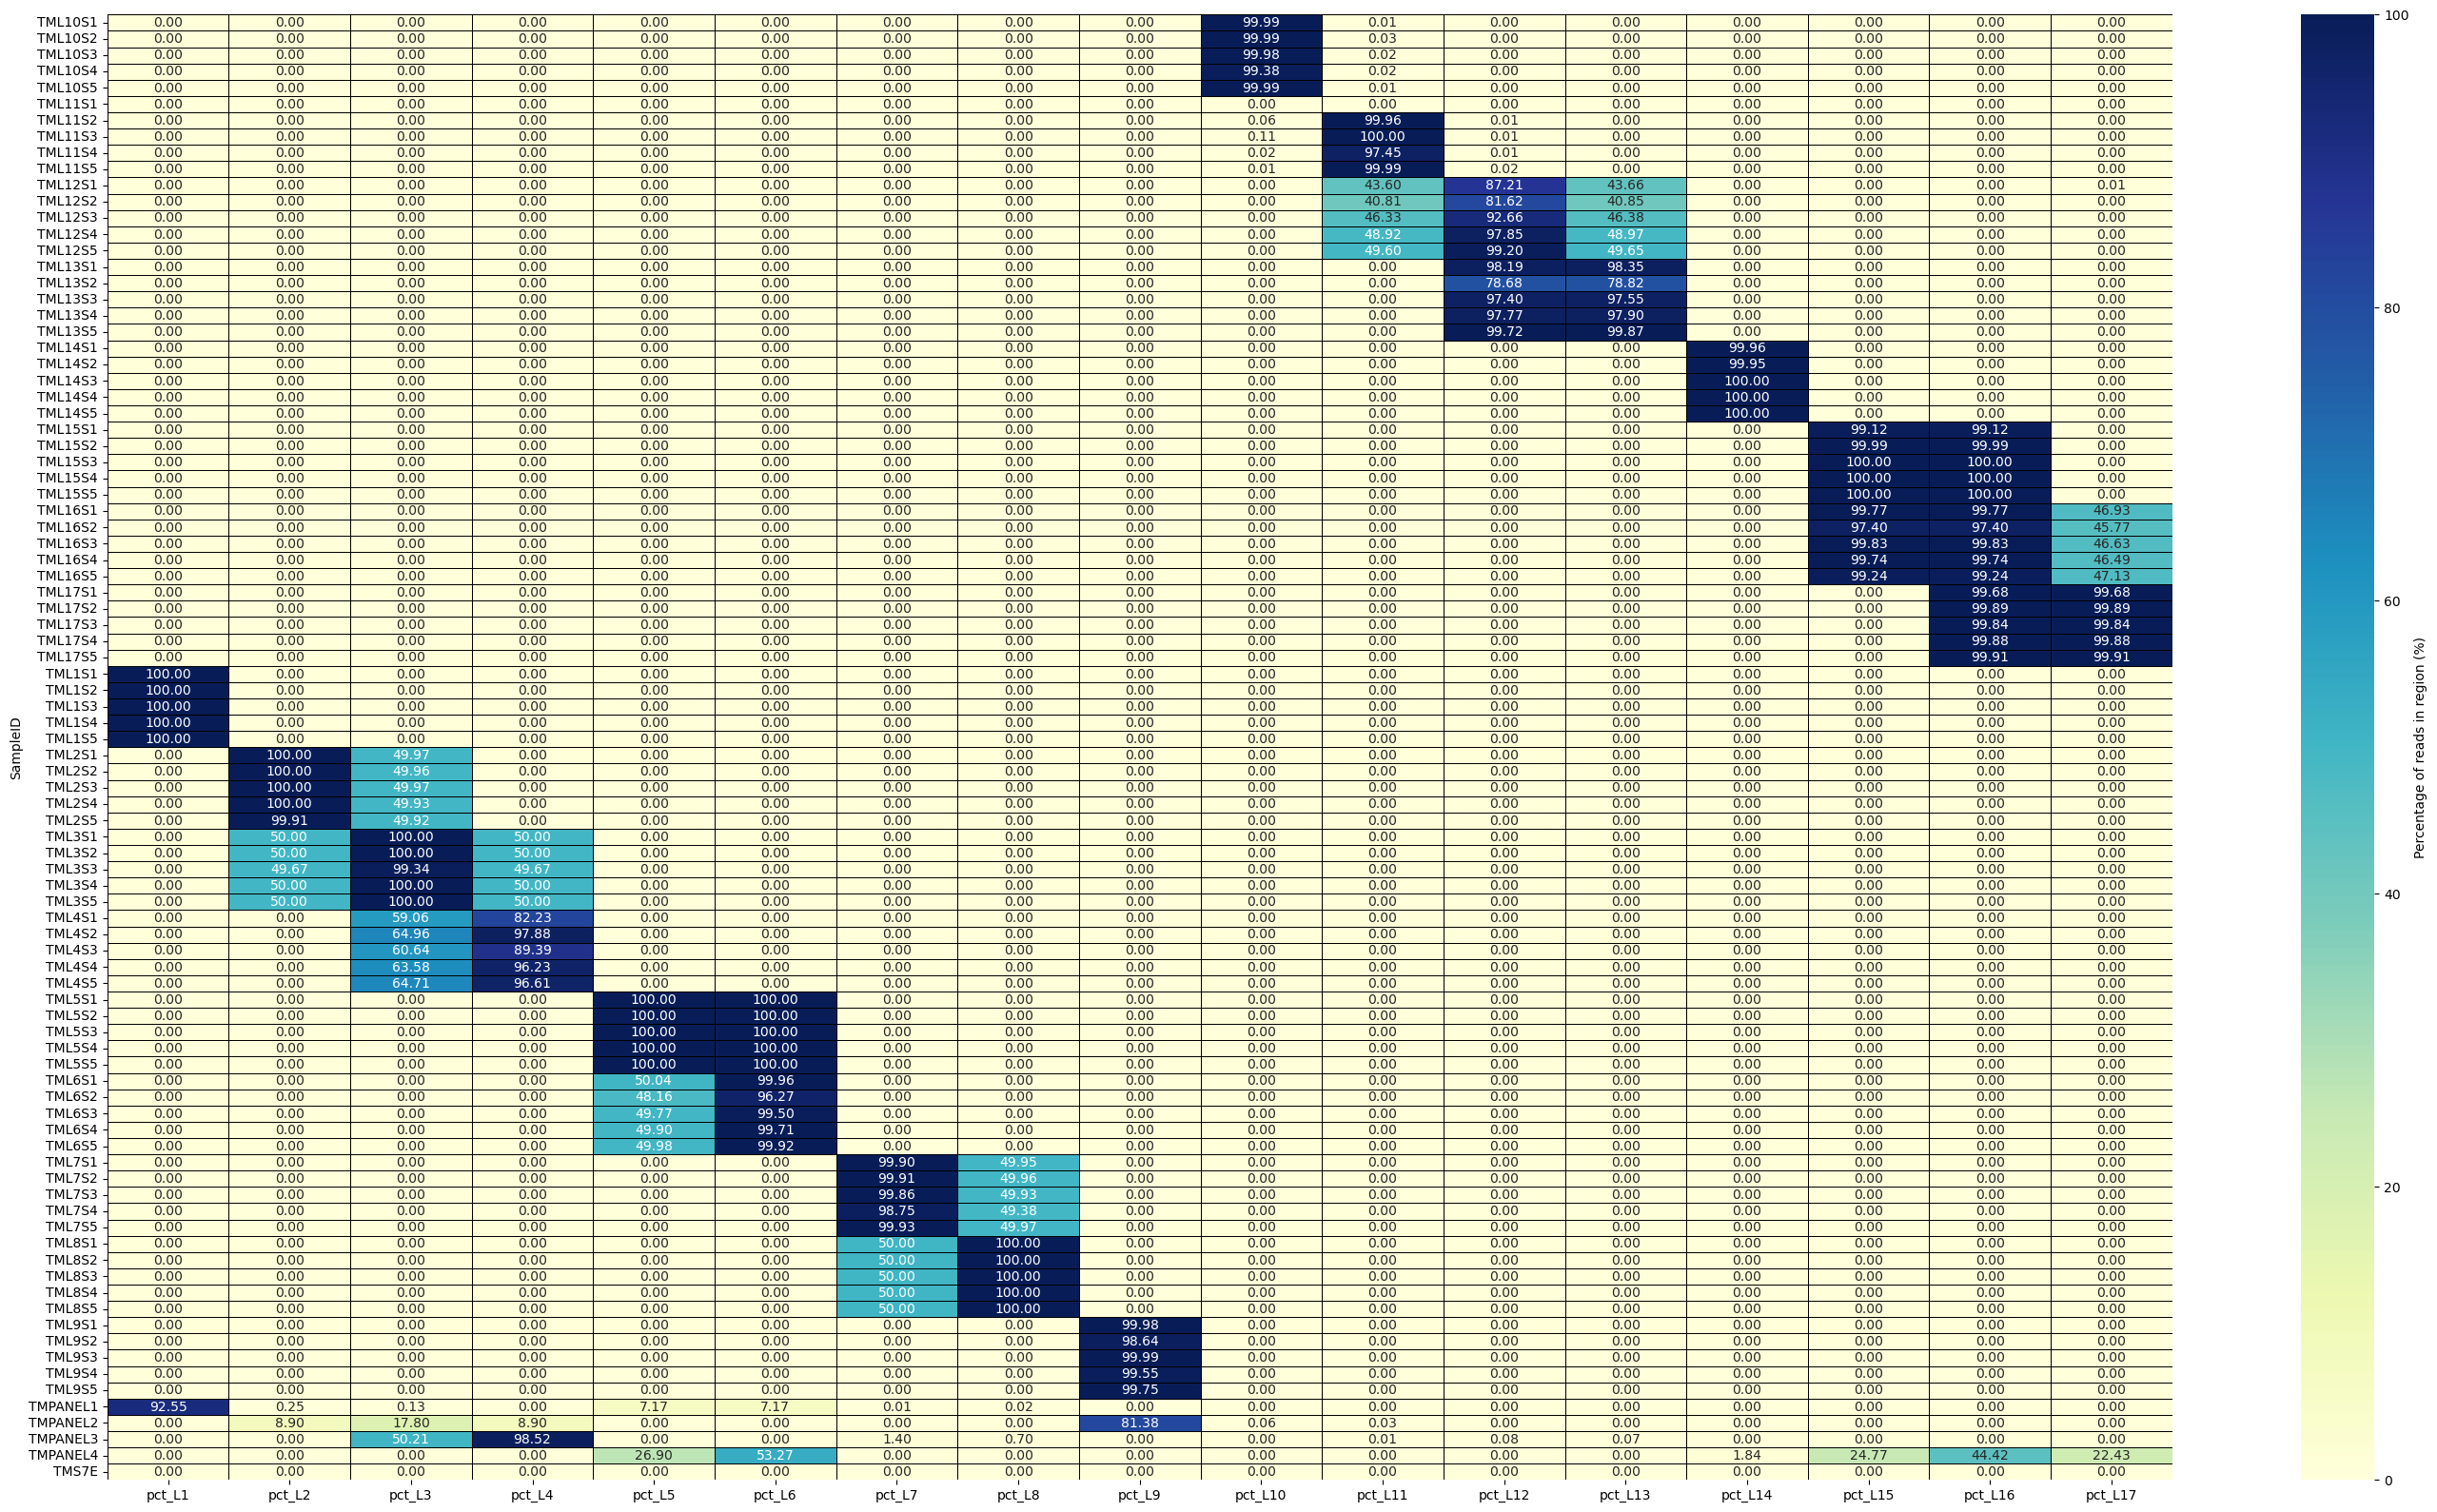

In [5]:
###### count on/off target reads
def count_read_in_region(bam_path, region, chr_mode = False):
    all_reads = []
    bamfile = pysam.AlignmentFile(bam_path, "rb")
    if chr_mode:
        region = f"chr{region}"
    fetched_obj = bamfile.fetch(region = region)
    for read in fetched_obj:
        all_reads.append(read)
    return(len(all_reads))

rerun = True
if os.path.isfile(os.path.join(path_to_01_output, f"read_count_in_region.xlsx")) == False or rerun == True:
    tqdm.pandas()
    metadata["num_total_reads"] = metadata["BAM"].progress_apply(lambda x: int(pysam.samtools.view("-c", x.replace(".bam", ".sorted.bam"), catch_stdout=True)))

    for bam_region in tqdm(paneldf[genome_version].unique()):
        region_name = paneldf[paneldf[genome_version] == bam_region]["Amplicon"].values[0]
        metadata[f"count_{region_name}"] = metadata["BAM"].apply(lambda x: count_read_in_region(x.replace(".bam", ".sorted.bam"), bam_region))
        metadata[f"pct_{region_name}"] = metadata[f"count_{region_name}"] / metadata["num_total_reads"] * 100
        
    metadata.to_excel(os.path.join(path_to_01_output, f"read_count_in_region.xlsx"), index = False)
else:
    print("File already exists, skip counting reads in regions. Reading existing data... ")
    metadata = pd.read_excel(os.path.join(path_to_01_output, f"read_count_in_region.xlsx"))

plotdf = metadata.sort_values(by = "amplicon")[[item for item in metadata.columns if "pct" in item] + ["SampleID"]].sort_values(by = "SampleID").set_index("SampleID")
plt.figure(figsize=(35, 20))
plt.tight_layout()
sns.heatmap(plotdf,cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Percentage of reads in region (%)"})
plt.savefig(os.path.join(path_to_01_output, "percentage_of_reads_in_regions.png"), dpi=300, bbox_inches='tight')

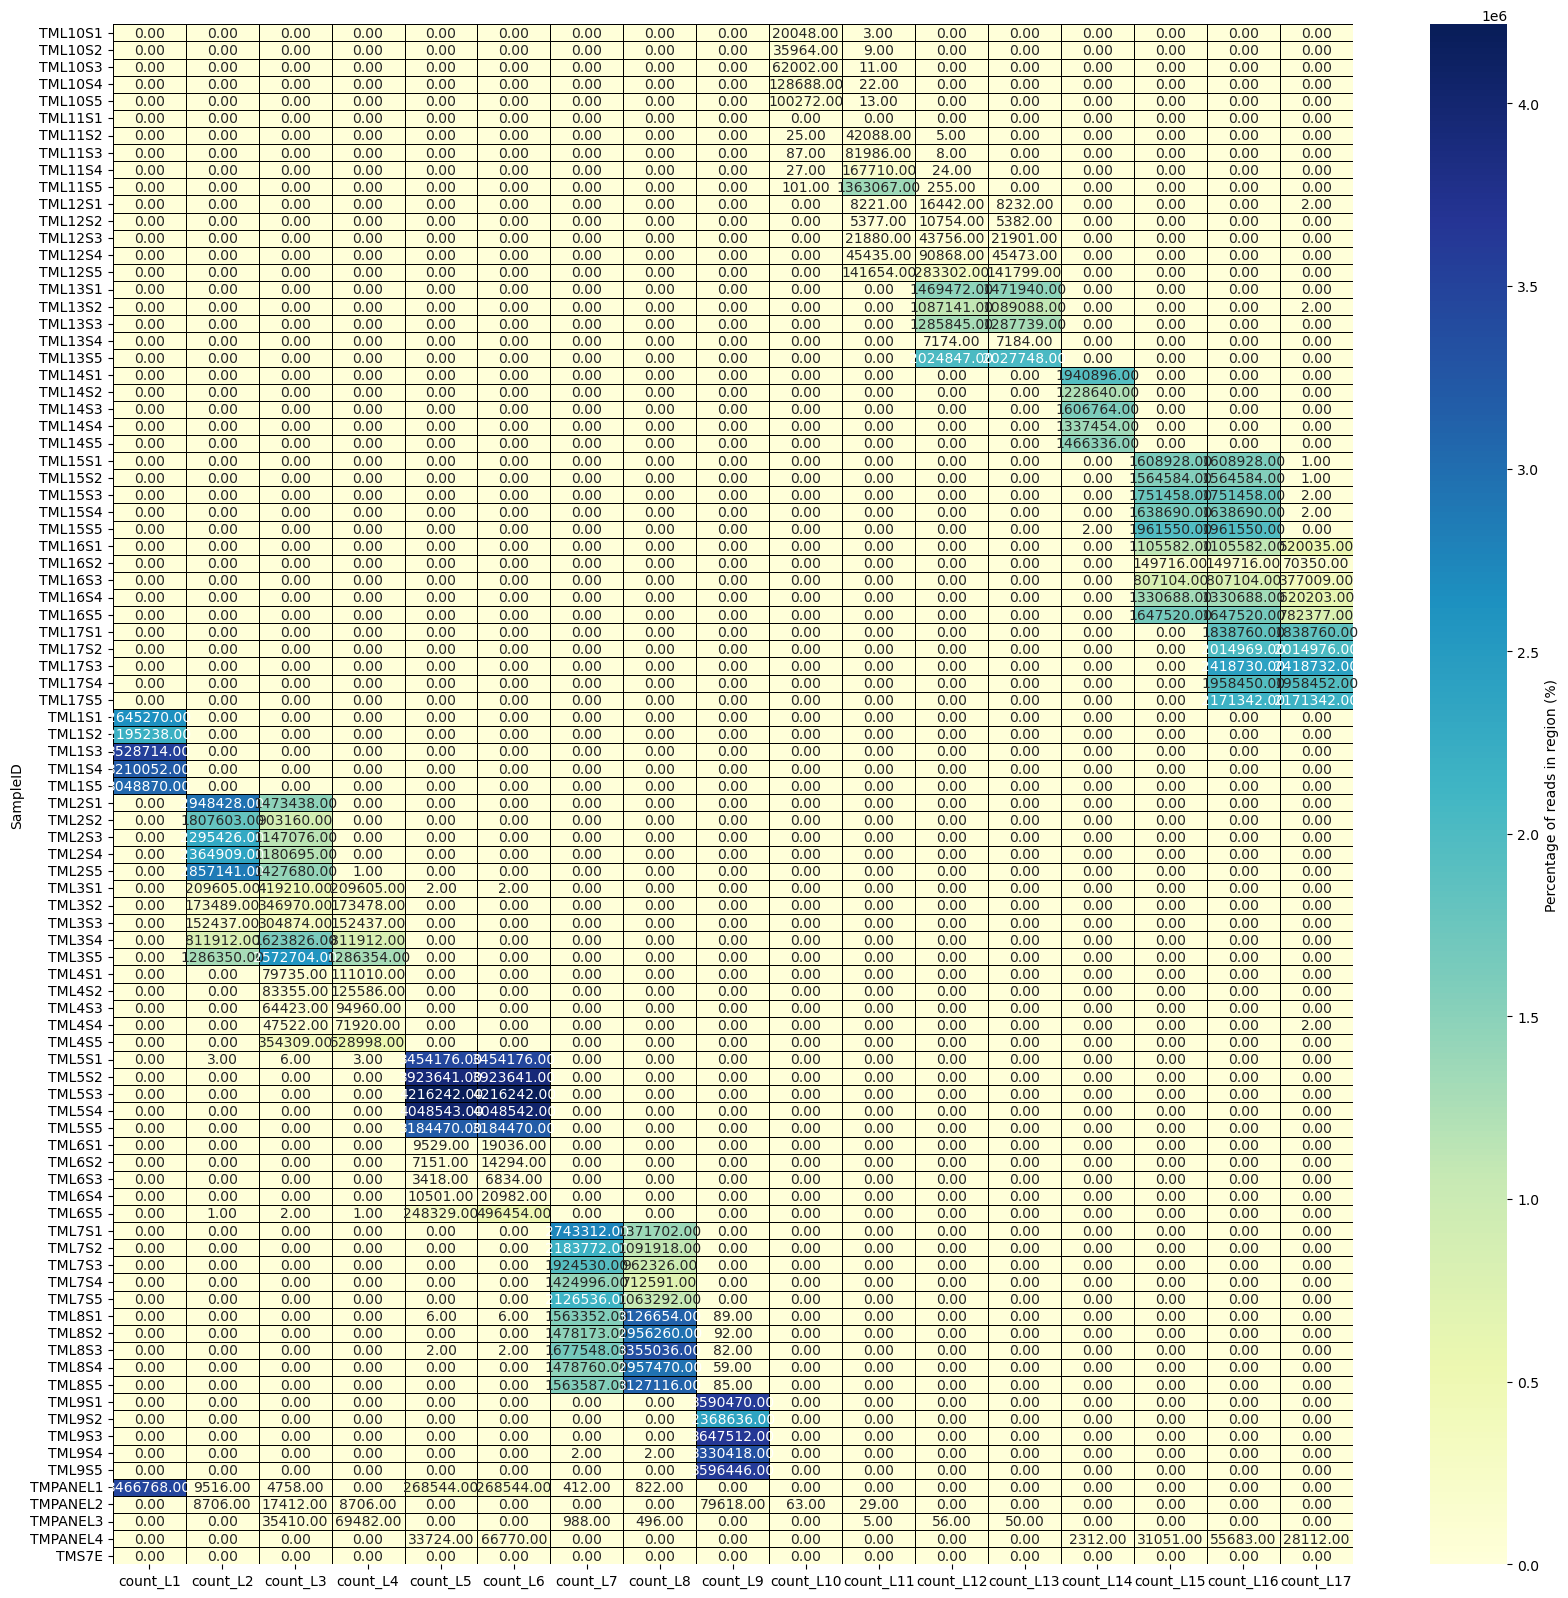

In [6]:
plotdf = metadata.sort_values(by = "amplicon")[[item for item in metadata.columns if "count" in item] + ["SampleID"]].sort_values(by = "SampleID").set_index("SampleID")
plt.figure(figsize=(20, 20))
plt.tight_layout()
sns.heatmap(plotdf,cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Percentage of reads in region (%)"})
plt.savefig(os.path.join(path_to_01_output, "number_of_reads_in_regions.png"), dpi=300, bbox_inches='tight')

In [7]:
metadata

,path,SampleID,Sample,amplicon,BAM,proc_cov_path,num_total_reads,count_L1,pct_L1,count_L2,...,count_L13,pct_L13,count_L14,pct_L14,count_L15,pct_L15,count_L16,pct_L16,count_L17,pct_L17
0,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TML7S3,S3,L7,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,1927172,0,0.0,0,...,0,0.000000,0,0.0,0,0.000000,0,0.000000,0,0.000000
1,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TML11S3,S3,L11,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,81990,0,0.0,0,...,0,0.000000,0,0.0,0,0.000000,0,0.000000,0,0.000000
2,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TML15S1,S1,L15,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,1623138,0,0.0,0,...,0,0.000000,0,0.0,1608928,99.124535,1608928,99.124535,1,0.000062
3,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TML13S3,S3,L13,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,1320148,0,0.0,0,...,1287739,97.545048,0,0.0,0,0.000000,0,0.000000,0,0.000000
4,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TMPANEL2,PANEL2,,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,97838,0,0.0,8706,...,0,0.000000,0,0.0,0,0.000000,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TML6S2,S2,L6,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,14848,0,0.0,0,...,0,0.000000,0,0.0,0,0.000000,0,0.000000,0,0.000000
86,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TML12S1,S1,L12,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,18854,0,0.0,0,...,8232,43.661822,0,0.0,0,0.000000,0,0.000000,2,0.010608
87,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TML6S1,S1,L6,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,19044,0,0.0,0,...,0,0.000000,0,0.0,0,0.000000,0,0.000000,0,0.000000
88,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,TML4S3,S3,L4,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/R7...,106234,0,0.0,0,...,0,0.000000,0,0.0,0,0.000000,0,0.000000,0,0.000000


In [8]:
methdf = pd.DataFrame()
for sampleid in tqdm(metadata.SampleID.unique()):
    covdf = pd.read_excel(metadata[metadata["SampleID"] == sampleid]["proc_cov_path"].values[0])
    covdf[covdf["check_context"] == "CpG_context"]
    tmpdf = pd.DataFrame(data = [sampleid], columns = ["SampleID"])
    for amplicon in paneldf["Amplicon"].unique():
        tmpdf[amplicon] = covdf[covdf["amplicon"] == amplicon]["meth_density"].mean()
    tmpdf.fillna(0, inplace = True)
    methdf = pd.concat([methdf, tmpdf], axis = 0)
methdf.sort_values(by = "SampleID", inplace = True)


100%|██████████| 90/90 [00:07<00:00, 11.26it/s]


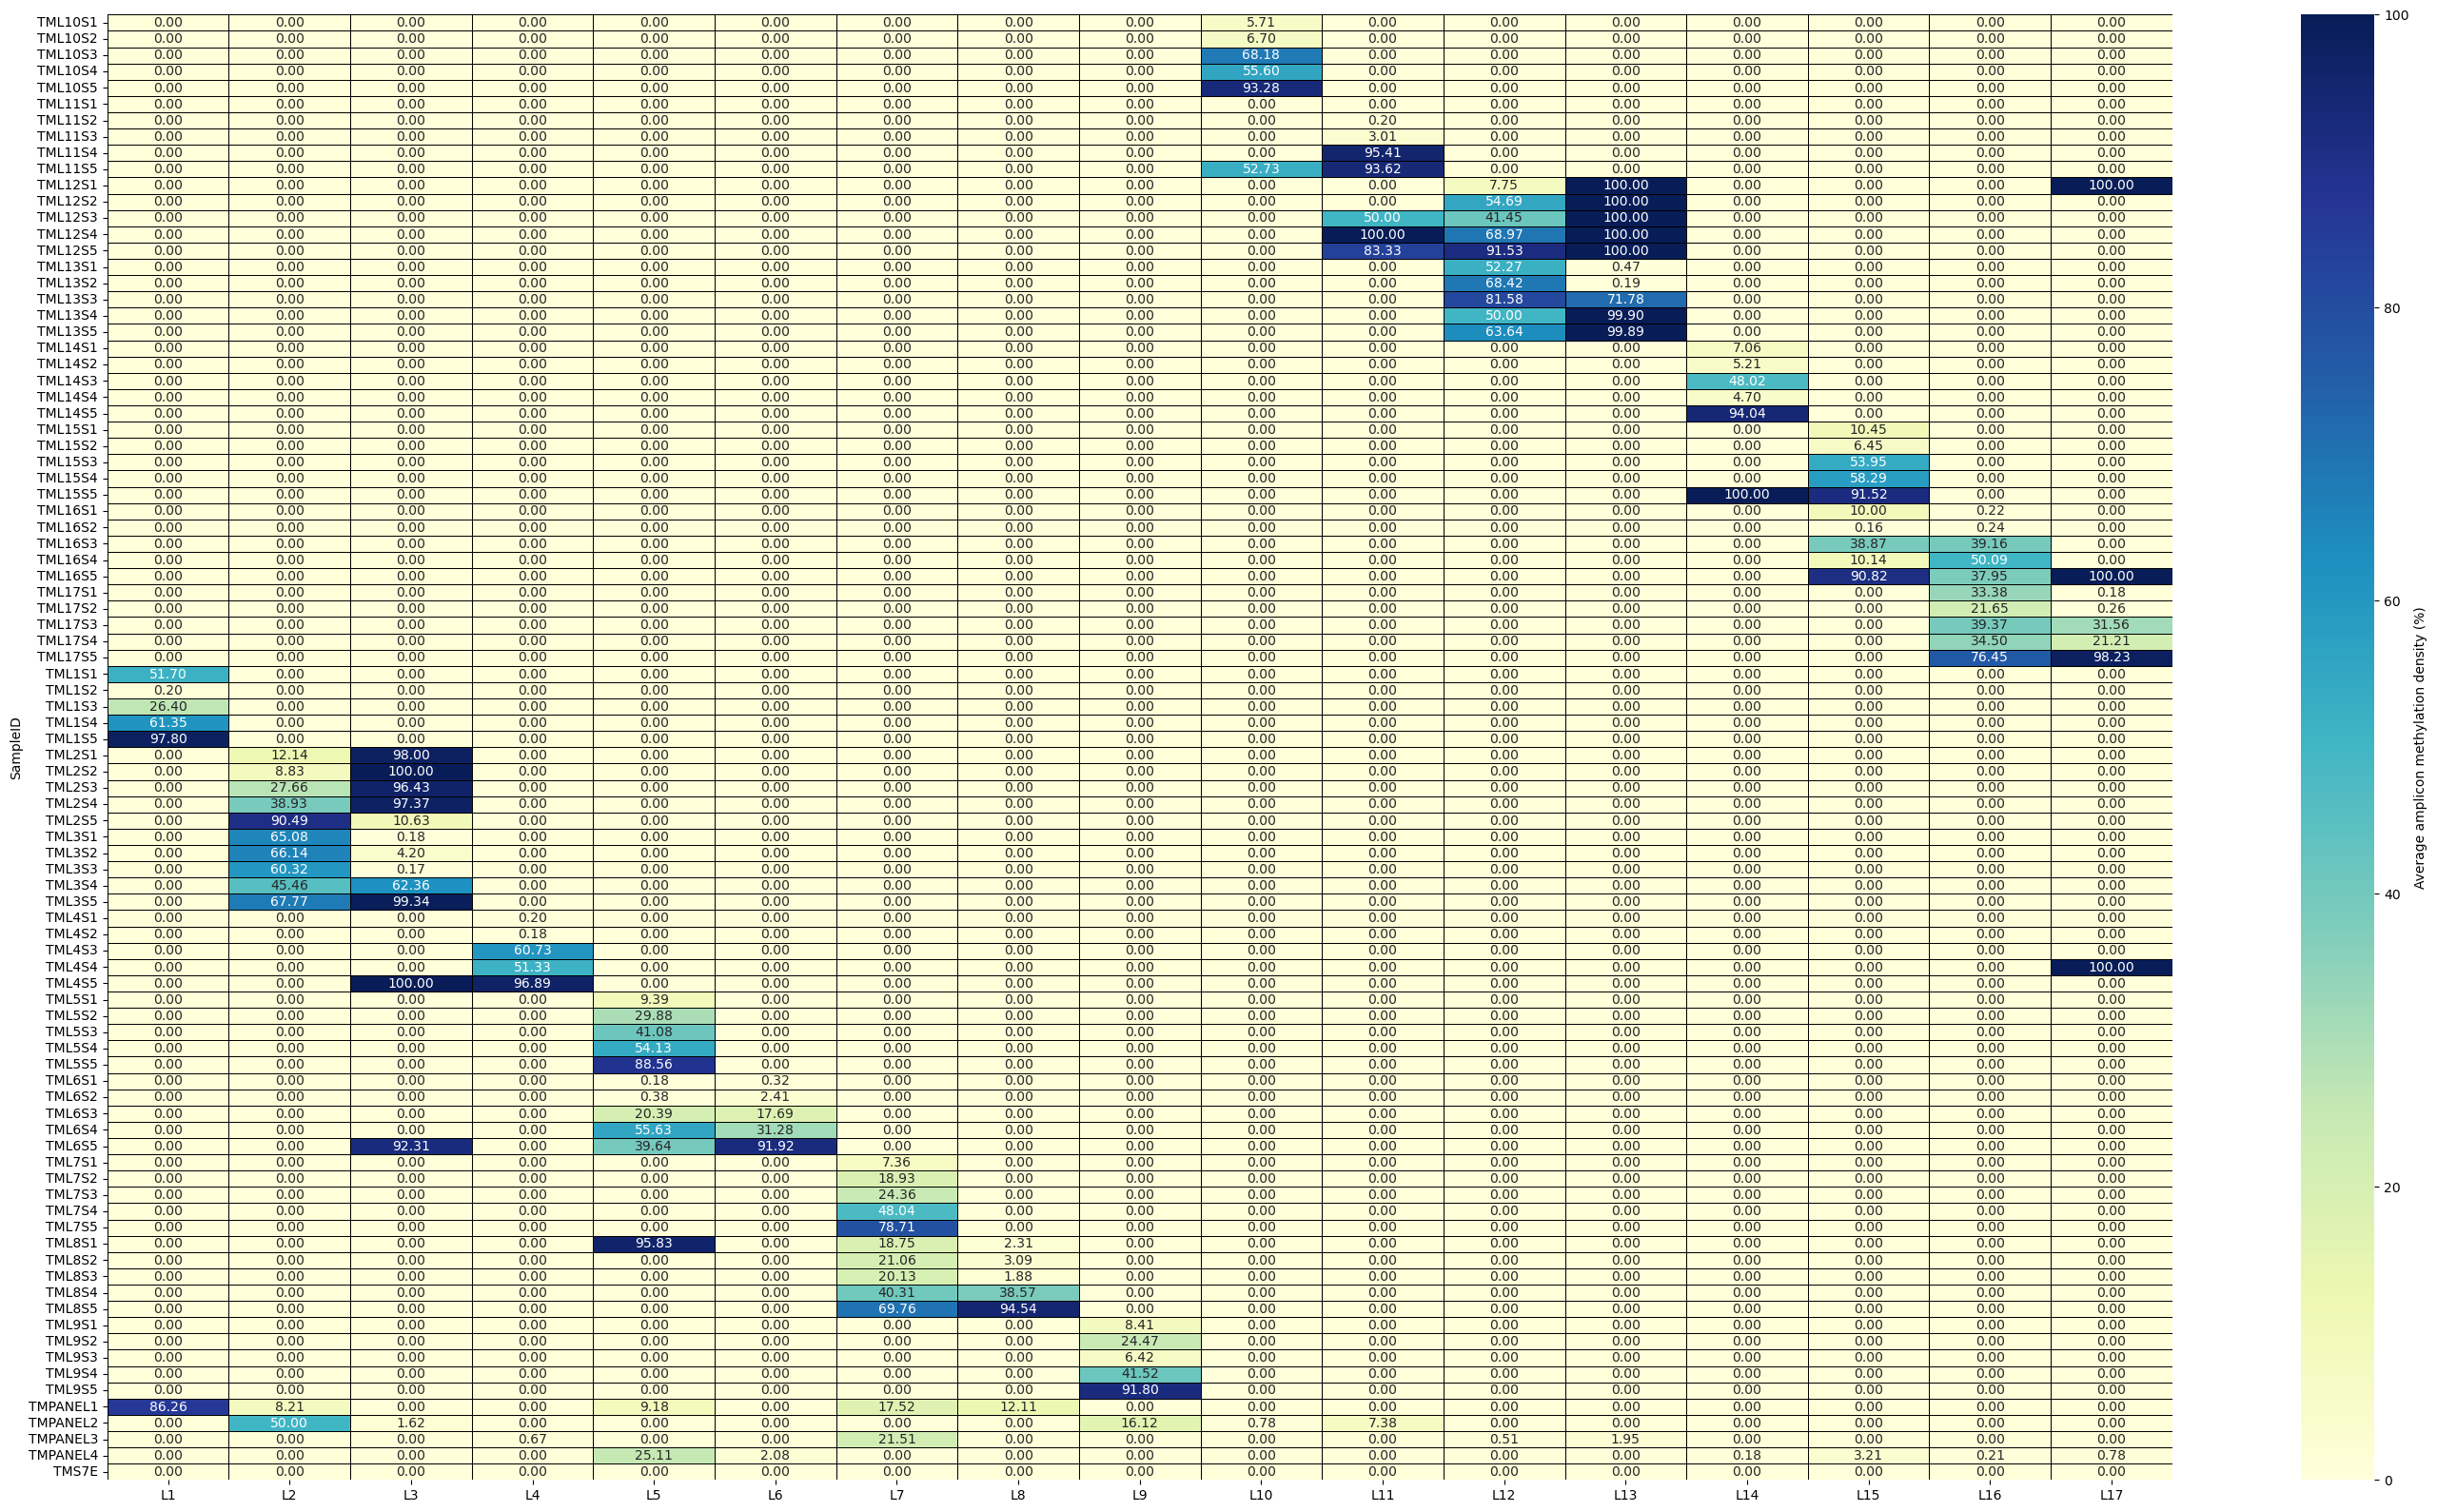

In [9]:
plt.figure(figsize=(35, 20))
plt.tight_layout()
sns.heatmap(methdf.set_index("SampleID"),cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Average amplicon methylation density (%)"})
plt.savefig(os.path.join(path_to_01_output, "amplicon_methylation_density_heatmap.png"), dpi=300, bbox_inches='tight')

In [10]:
cpg_count_amplicon = cpgdf.groupby("region_name")["CpG"].count().reset_index()
cpg_count_amplicon

,region_name,CpG
0,L1,4
1,L10,12
2,L11,15
3,L12,8
4,L13,7
5,L14,10
6,L15,8
7,L16,8
8,L17,2281
9,L2,14


In [11]:
methdf = pd.DataFrame()
for sampleid in tqdm(metadata.SampleID.unique()):
    covdf = pd.read_excel(metadata[metadata["SampleID"] == sampleid]["proc_cov_path"].values[0])
    covdf[covdf["check_context"] == "CpG_context"]
    tmpdf = pd.DataFrame(data = [sampleid], columns = ["SampleID"])
    for amplicon in paneldf["Amplicon"].unique():
        tmpdf[amplicon] = 100 * len(covdf[covdf["amplicon"] == amplicon].CpG.unique())/ cpg_count_amplicon[cpg_count_amplicon["region_name"] == amplicon]["CpG"].values[0]
    tmpdf.fillna(0, inplace = True)
    methdf = pd.concat([methdf, tmpdf], axis = 0)
methdf.sort_values(by = "SampleID", inplace = True)

100%|██████████| 90/90 [00:08<00:00, 11.15it/s]


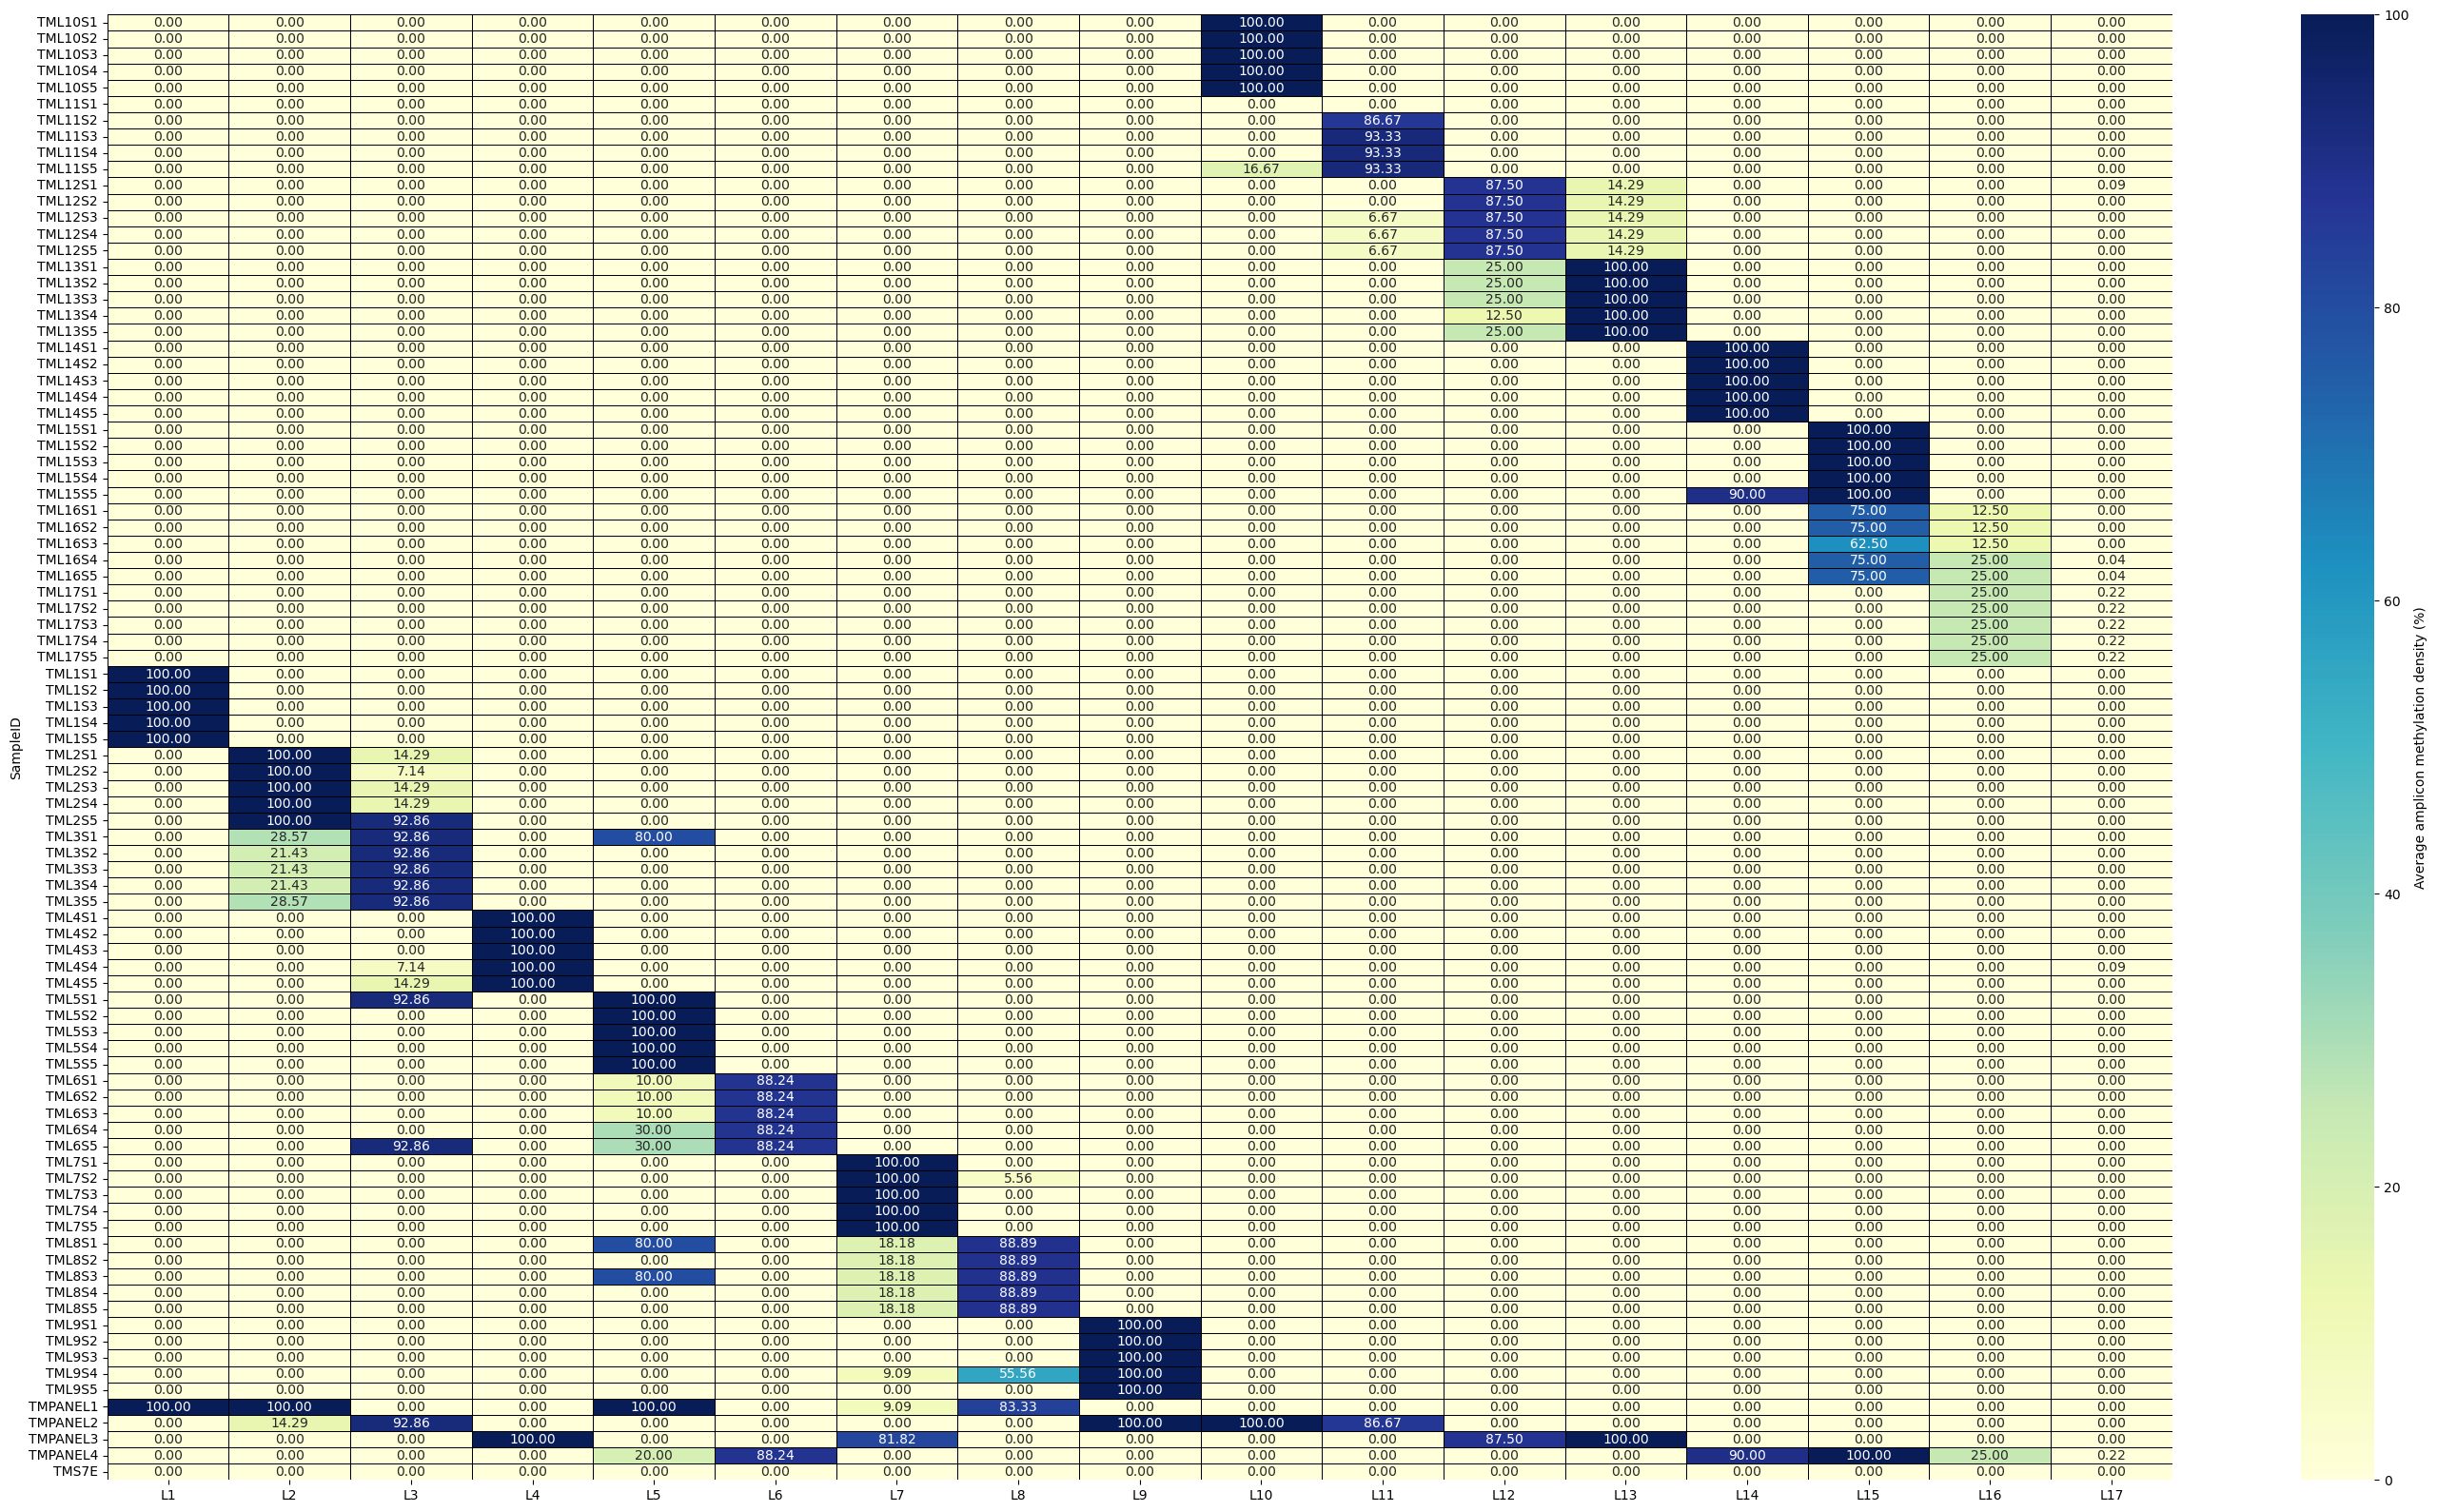

In [12]:
plt.figure(figsize=(35, 20))
plt.tight_layout()
sns.heatmap(methdf.set_index("SampleID"),cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Average amplicon methylation density (%)"})
plt.savefig(os.path.join(path_to_01_output, "percentage_of_captured_cpg_in_amplicons.png"), dpi=300, bbox_inches='tight')